# Using XApRES
A guide to using the package XApRES to load ApRES data into xarrays. This is the primary purpose of XApRES. 

There are two ways to use the package corresponding to ApRES data collected in (1) Attended mode and (2) Unattended mode. In attended mode, an ApRES measurement (typically 1 or a few 'bursts', i.e. collections of chirps) are made then the radar is moved or just its antennas are moved, then another measurement if made. In unattended mode, the radar performs repeated measurements at regular intervals autonomously. The timing of the measurements is determined by a configuration file loaded onto the radar by the user. 

The structure of the xarray produced when loading each type of data with XApRES is different. In the examples below we note what type of data is being loaded in each example. 

## Loading in the XApRES package
If you pip installed the package with `pip install xapres`, you import the package as follows:

```
import xapres as xa
```

If instead you cloned the XApRES repo from https://github.com/ldeo-glaciology/xapres you must (1) install dependencies using 

```
conda env create -f environment.yml
```

then add the xapres repository to your python path before loading the package. If you are running this notebook from its location in the repo (xapres/notebooks/guides) the following works:

```
import sys
sys.path.append("../../../xapres/")
```

More generally, if `dir_containing_xapres_repo` is the absolute path to the directory containing the xapres repository, the following will work. 
```
import sys
sys.path.append(dir_containing_xapres_repo + "/xapres/")
```


In [1]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append("../../../xapres/")
import xapres as xa
import numpy as np


## The load module
The package includes a module for loading ApRES data from different locations - currently these locations include from the dat files that the radar produces directly, and from processed data stored in a zarr directory. 

This module can be accessed as `xapres.load` (or in this case `xa.load` as that is the alias we have used above).

Two high-level functions `load_zarr` and `generate_xarray` are included to perform these two tasks. We will demonstrate these below, before digging in deeper to demonstrate how to use the lower-level functions that `generate_xarray` calls.

### `load_zarr`
The following code uses `load_zarr` to load a ApRES dataset collected in unattended mode, which was previously loaded into an xarray and then put in cloud storage in the form of a zarr directory. Zarr directories are like cloud-optimized netcdf files. 

Loading this data will enable us to take a look at the structure of the xarray. Note that this is an unattended ApRES dataset. An xarray produced by this package for attended ApRES data will have a different structure. 

In [2]:
from_zarr = xa.load.load_zarr()
from_zarr

<xarray.Dataset> Size: 203GB
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 94kB dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U83 4MB dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 94kB 2022-05-22T19:40:20 ... 2022-...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 94kB dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 150GB dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 94kB dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 94kB dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 50GB dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 2GB dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 94kB dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 94kB dask.array<chunksize=(20,), meta=np.ndarray>

The resulting xarray has five dimensions:
- `attenuator_setting_pair`: ApRES has two adjustable settings that we refer to here a AFGain and attenuator. For simplicity we refer to them collectivley as attenutator settings. For data collection with ApRES in unattended mode, the user can config the system to cycle through multiple pairs of attenuator settings during each burst of data collection. The result is binary files (with the extension .DAT) containing data using different attenuator settings interleaved with one another. Once the data is rearranged in an xarray, these different settings can be selected using the dimension attenuator_setting_pair.
- `time`: the time of aquisistion of each burst of data. In unattended mode data is collected at regular intervals, so it makes sense to have time as a dimension. 
- `chirp_time`: the time since beginning of each chirp of each sample within a chirp. As each chirp lasts 1 second, chirp_time varies from 0 to 1 second. There are 40001 samples by default, so the length of `chirp_time` is 40001. 
- `chirp_num`: this is number of chirps in each burst using each attenuator_setting_pair. So if the ApRES unit was configure to use 2 attenuator setting pairs and make 20 chirps for each in each burst, the total number of chirps in a burst will be 2x20 = 40. 
- `profile_range`: the range to each sample in the profiles computed from each chirp using an fft. 

The two most important data variables are:
- `chirp`: the voltage measured during each chirp after the received signal is mixed with the simultaneously transmitted signal and low-pass filtered. This is an array of real values. 
- `profile`: the profile resulting from an fft of the chirp. This is an array of complex values.
  
Note that both of these data variables are 4-D. They share three dimensions (not in any particular order): `time`, `chirp_num`, and `attenuator settings_pair`. The variables' fourth dimensions are different. `chirp`'s fourth dimentsion is the sampling time `chirp_time`. `profile`'s fourth dimension is the range to each measurement `profile_range`.

We will include lots of examples of how to plot these data below. For now it suffices to say that you can use xarray's powerful, high-level slicing and plotting methods to take a quick look at the data. For example, to plot the 10th chirp from the 100th burst, using the first attenuator pair:

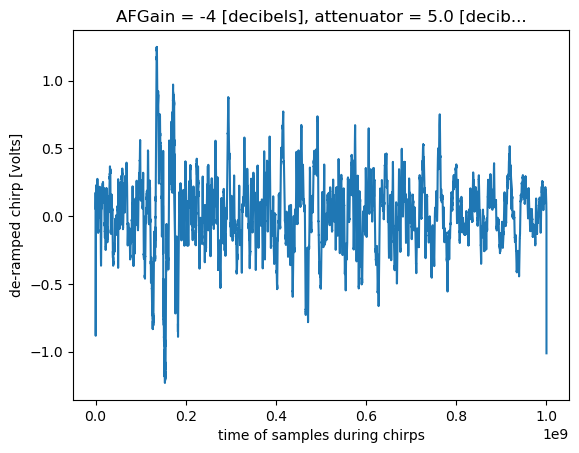

In [3]:
from_zarr.chirp.isel(time=100, chirp_num=10, attenuator_setting_pair=0).plot();

### `generate_xarray`
#### Unattended data
This function provide a simple interface for loading data stored in data files, performing initial processing, and structuring the data as an xarray. 

The simplest case is when the ApRES data was collected in unattended mode and stored in many dat files. You provide a directory to `generate_xarray` and the lower-level methods will search recursively through all its subdirectories, perform a fourier transform on the raw data to compute complex profiles as a function of depth, and return an xarray. In the following we also supplied the option arguments `file_numbers_to_process` and `bursts_to_process` in order to just load, process, and return one of the bursts from one file, simply to save time.   

In [2]:
from_DAT_unattended = xa.load.generate_xarray(directory='../../data/sample/single_dat_file/', 
            file_numbers_to_process = [0], 
            bursts_to_process=[0],
            )
from_DAT_unattended

<xarray.Dataset> Size: 51MB
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 8B 2023-01-05T03:16:15
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U57 228B '../../data/sample/single_dat_file/DATA...
    burst_number     (time) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
    orientation      (time) <U7 28B 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 32MB ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 19MB ...
    latitude         (time) float64 8B 0.0
    longitude        (time) float64 8B 0.0
    battery_voltage  (time) float64 8B 0.0
    temperature_1    (time) float64 8B 2.891
    temperature_2    (time) float64 8B 511.8

Note that we are again assuming these data were collected in unattended mode, therefore the resulting xarray has very similar structure to the one we loaded from the zarr directory above. 

#### Attended data

We could also load these data and tell the function that they were collected in attended mode, and the resulting xarray will have a stucture more suitable for the kind of survey (note that `waypoint` and `orientation` are additional dimensions and `time` is absent from the list of dimensions). The code assumes that one dat file from each waypoint is stored in each item of the list `directory`.

In [2]:
from_DAT_attended = xa.load.generate_xarray(directory=['../../data/sample/single_dat_file/'], 
            file_numbers_to_process = [0], 
            bursts_to_process=[0],
            attended=True
            )
from_DAT_attended

<xarray.Dataset> Size: 51MB
Dimensions:          (orientation: 1, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 8B 2023-01-05T03:...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (orientation, waypoint) <U57 228B '../../data/sample/sin...
    burst_number     (orientation, waypoint) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
  * orientation      (orientation) <U7 28B 'unknown'
  * waypoint         (waypoint) int64 8B 1
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 32MB ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 19MB ...
    latitude         (orientation, waypoint) float64 8B 0.0
    longitude        (orientation, waypoint) float64 8B 0.0
    battery_voltage  (orientation, waypoint) float64 8B 0.0
    temperature_1    (orientation, waypoint) float64 8B 2.891
    temperature_2    (orientation, waypoint) float64 8B 511.8

Finally, you can also specify that the data is a polarmetric survey. For now, this simple assumes that at each waypoint four measurements were made with four different antenna orientations: HH, HV, VH, VV.

In [6]:
from_polametricDAT = xa.load.generate_xarray(attended=True, 
                directory=["../../data/sample/polarmetric"], 
                polarmetric=True)
from_polametricDAT

<xarray.Dataset> Size: 205MB
Dimensions:          (orientation: 4, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 32B 2023-01-05T03...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (orientation, waypoint) <U56 896B '../../data/sample/pol...
    burst_number     (orientation, waypoint) int64 32B 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
  * orientation      (orientation) <U2 32B 'HH' 'HV' 'VH' 'VV'
  * waypoint         (waypoint) int64 8B 1
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 128MB ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 76MB ...
    latitude         (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    longitude        (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    temperature_1    (orientation, waypoint) float64 32B 502.9 503.1 2.891 2.492
    temperature_2    (orientation, waypoint) float64 32B 501.6 503.6 511.8 4.93

## Lower-level methods
Next let's dig in deeper to some lower levels functions that are called by `load.generate_xarray`. The code at this level is object oriented and the main object that you initialize and interact with is called `from_dats`. It is an object that contains metadata and data loaded from the binary files that ApRES produces (which have the extension .dat). 

### Initialize data_loaded_from_dats 
Calling `data_loaded_from_dats` initializes an object which will contain our data and has methods associated with it which we will use to load and process the data.

When initalizing you have the option of setting the logging level. This determines how detailed the logging messages will be. To make it as detailed as possible, set it to 'debug'.

In [7]:
fd = xa.load.from_dats(loglevel='debug')

DEBUG    15:13:02 	 load.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:13:02 	 load.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:13:02 	 load.py @function _setup_logging line 629 - File logging level set to DEBUG


### `list_files`: list dat files 
As mentioned above, ApRES data is stored in binary files with the extension `.dat`.

The method `list_files` recursively lists all the dat files in a given directory or cloud-based file-like location. 

If you have dat files in your current directory, you can simply run `filepaths = from_dat.list_files()` to produce a list of the dat files.

In our case, we have dat files are in cloud storage in a google bucket. To load from a google bucket you must provide the path to the bucket as the first argument `directory` and flag that this is a remote load by defining `remote_load=True`. The following cell produces a list of all the dat files in the google bucket and prints out the first five.

In [8]:
filepaths = fd.list_files(directory='gs://ldeo-glaciology/GL_apres_2022', remote_load = True)
filepaths[0:5]

DEBUG    15:13:02 	 load.py @function list_files line 147 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022 with remote_load = True
DEBUG    15:13:02 	 load.py @function list_files line 161 - Finish call to list_files. Found 1928 files


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-26-1536.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-27-1506.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-28-1436.DAT']

The list of filenames is also stored as one the attributes of `fd_unattened`:

In [9]:
fd.dat_filenames[0:5]

['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-26-1536.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-27-1506.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-28-1436.DAT']

### `load_single`: load one of these files
The method `load_single` loads a single dat file and produces bursts and chirps from the loaded data:

In [10]:
fd.load_single(filepaths[0], remote_load=True)

DEBUG    15:13:02 	 load.py @function load_single line 121 - Load dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT with remote_load = True
DEBUG    15:13:06 	 load.py @function load_single line 123 - Extract burst number 0
DEBUG    15:13:08 	 load.py @function load_single line 125 - Extract chirp number 0
DEBUG    15:13:08 	 load.py @function load_single line 127 - Form profile for chirp number 0
DEBUG    15:13:08 	 load.py @function load_single line 129 - Finish call to load_single.


The results are stored in `from_dat` and you can either plot them yourself using matplotlib or similar, or use a built-in plotting function `PlotProfile` for a quick look:

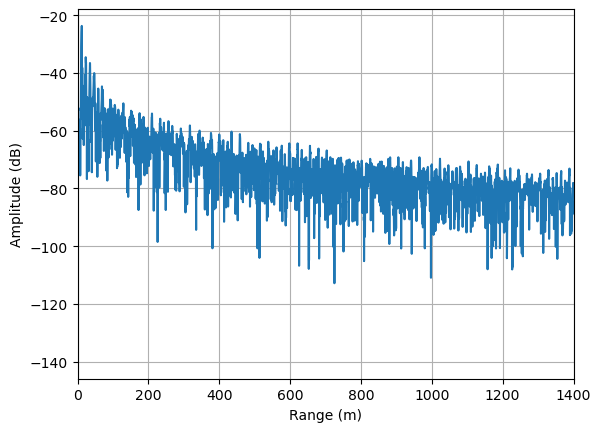

In [11]:
fd.single_profile.PlotProfile(1400);

## Put multiple bursts in an xarray

This is the main purpose of the package. We want to loop through all our dat files and store them in a convenient way. 

The best structure for the resulting data structure depends on if the data were collected in unattended or attended model. 

### Unattended mode
In unattended mode ApRES operates autonomously and performs bursts at regular intervals. The burst consist of multiple chirps arranged in sub-bursts. Chirps in a sub-burst all use the same attenuator settings. See the [ApRES manual](https://github.com/ldeo-glaciology/phase-sensitive-radar-processing/blob/b09870189b1655b2745d751e58c06b754320f6ab/other%20documents/ApRES%20Manual%20V102.1.pdf) for more details.

For unattended data we loop through all the bursts in each dat file, and compute the profile for each one and store it all in the order in which it was collected. That is, `time` is a important dimension of the data. 

The method `load_all` performs these loops and puts the resulting xarray in an attribute of `fd_unattended` called `data` (to access it you just call `fd_unattended.data`). 

In general we would like to loop over all bursts and dat files, but for this demonstration let's just process two dat files and two bursts from each dat file. `load_all` takes several optional arguments. For example, `file_numbers_to_process` and `bursts_to_process`, which are lists of the dat files and burst to process:

In [12]:
fd_unattended = xa.load.from_dats(loglevel='debug')
fd_unattended.load_all(directory='gs://ldeo-glaciology/GL_apres_2022', 
            remote_load = True,
            file_numbers_to_process = [0, 1], 
            bursts_to_process=[0, 1]
           )
fd_unattended.data

DEBUG    15:13:08 	 load.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:13:08 	 load.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:13:08 	 load.py @function _setup_logging line 629 - File logging level set to DEBUG
DEBUG    15:13:08 	 load.py @function load_all line 195 - Start call to load_all with remote_load = True, directory = gs://ldeo-glaciology/GL_apres_2022, file_numbers_to_process = [0, 1], file_names_to_process = None, bursts_to_process = [0, 1], attended = False
DEBUG    15:13:08 	 load.py @function list_files line 147 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022 with remote_load = True
DEBUG    15:13:09 	 load.py @function list_files line 161 - Finish call to list_files. Found 1928 files
DEBUG    15:13:09 	 load.py @function subset_files line 265 - Subset files to [0, 1]
DEBUG    15:13:09 	 load.py @function load_all line 208 - Attended is False, so starting loop over da

<xarray.Dataset> Size: 47MB
Dimensions:          (time: 3, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 4280)
Coordinates:
  * time             (time) datetime64[ns] 24B 2022-05-22T19:40:20 ... 2022-0...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 34kB 0.0 0.2103 ... 899.6 899.8
  * chirp_num        (chirp_num) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
    filename         (time) <U83 996B 'ldeo-glaciology/GL_apres_2022/A101/Car...
    burst_number     (time) int64 24B 0 1 0
    AFGain           (time, attenuator_setting_pair) int64 48B -14 -14 ... -14
    attenuator       (time, attenuator_setting_pair) float64 48B 10.0 ... 5.0
    orientation      (time) <U7 84B 'unknown' 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 38MB ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 8MB ...
    latitude         (time) float64 24B 69.22 69.22 68.71
    longitude        (time) float64 24B -51.12 -51.12 -49.55
    battery_voltage  (time) float64 24B 12.33 12.48 13.93
    temperature_1    (time) float64 24B 4.383 7.32 2.812
    temperature_2    (time) float64 24B 5.195 1.469 2.25

The xarray only contains three bursts (`len(xa.data.time) = 3`) because, although we asked for bursts 0 and 1 from each file, the second file only had one burst in it. `_all_bursts_in_dat_to_xarray` catches this issue when it comes up and only tries to load bursts that exist in each dat file. 

### Attended mode
When operating ApRES in attended mode you manually start individual bursts one after another. Between bursts you move the whole system or change the antenna orientations if you are doing a polarmetric survey. 

As mentioned above in the section o nthe higher-level function `generate_xarrays`, we load these data into an xarray with a different structure to unattended data. The most important difference is that the dimension `time` is replaced by `waypoint`. Time is still stored, as it is an important part of the dataset, it just is not a dimension. 

To load ApRES data collected in atteneded mode you pass the option `attended=True` to `load_all`. In this case you can provide a list of directories via the `directory` arguement correspding to each waypoint. There should be just one .dat file in each directory. However, if the survey was polarmetric you should set `polarmetirc=True` and each directory should have four .dat files, each corresponding a pair of antenna orientations HH, HV, VH and VV. 

First let's load a single, non-polametric dataset and look at the result. Notice the difference in the structure compared to `fd_unattended.data` above. (We will turn off the debugging output this time for clarity).

In [13]:
fd_attended = xa.load.from_dats(loglevel='debug')
fd_attended.load_all(attended=True, 
                     directory=["../../data/sample/single_dat_file"])
fd_attended

DEBUG    15:13:21 	 load.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:13:21 	 load.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:13:21 	 load.py @function _setup_logging line 629 - File logging level set to DEBUG
DEBUG    15:13:21 	 load.py @function load_all line 195 - Start call to load_all with remote_load = False, directory = ['../../data/sample/single_dat_file'], file_numbers_to_process = None, file_names_to_process = None, bursts_to_process = All, attended = True
DEBUG    15:13:21 	 load.py @function load_all line 231 - Attended is True, so starting loop over directories (each corresponding to a waypoint)
DEBUG    15:13:21 	 load.py @function load_all line 235 - Looking in directory ../../data/sample/single_dat_file for dat files from waypoint 1
DEBUG    15:13:21 	 load.py @function _all_bursts_at_waypoint_to_xarray line 347 - Looking for files with orientation  in directory ../../data/sample/single_dat_fi

Next let's load a polarmetric dataset and look at the results:

In [14]:
fd_polarmetric = xa.load.from_dats(loglevel='debug')
fd_polarmetric.load_all(attended=True, 
                     directory=["../../data/sample/polarmetric"], 
                     polarmetric=True)
fd_polarmetric

DEBUG    15:13:22 	 load.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:13:22 	 load.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:13:22 	 load.py @function _setup_logging line 629 - File logging level set to DEBUG
DEBUG    15:13:22 	 load.py @function load_all line 195 - Start call to load_all with remote_load = False, directory = ['../../data/sample/polarmetric'], file_numbers_to_process = None, file_names_to_process = None, bursts_to_process = All, attended = True
DEBUG    15:13:22 	 load.py @function load_all line 231 - Attended is True, so starting loop over directories (each corresponding to a waypoint)
DEBUG    15:13:22 	 load.py @function load_all line 235 - Looking in directory ../../data/sample/polarmetric for dat files from waypoint 1
DEBUG    15:13:22 	 load.py @function _all_bursts_at_waypoint_to_xarray line 347 - Looking for files with orientation HH in directory ../../data/sample/polarmetric
DEBUG  

## Plotting 
Once you have an xarray, no matter if you used the higher-level functions `load_zarr` and `generate_xarray` or the lower-level `load.from_dats`, you can use xarray's convenient reduction (e.g., mean, coursen), slicing and plotting methods to inspect and analyze the data. 

We will use the data loaded with `load_zarr` above.

This datast is large:

In [15]:
print(f"{from_zarr.nbytes/1e9} GB")

202.513838596 GB


so we dont to try and plot all of it. Instead we will slice out just the chirps in one burst, with all attenuator settings

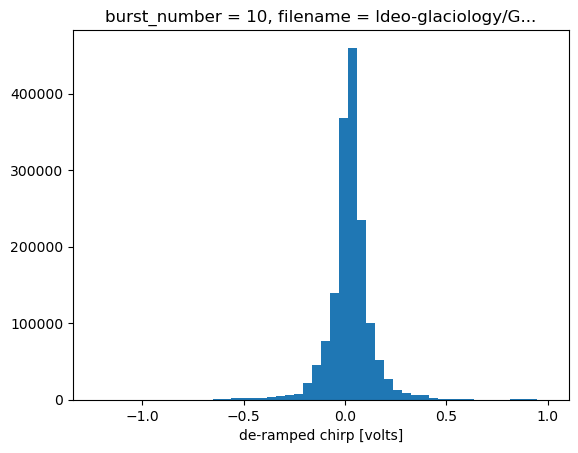

In [16]:
from_zarr.chirp.isel(time=400).plot(bins = 50);

Next we can plot individual chirps, for example,

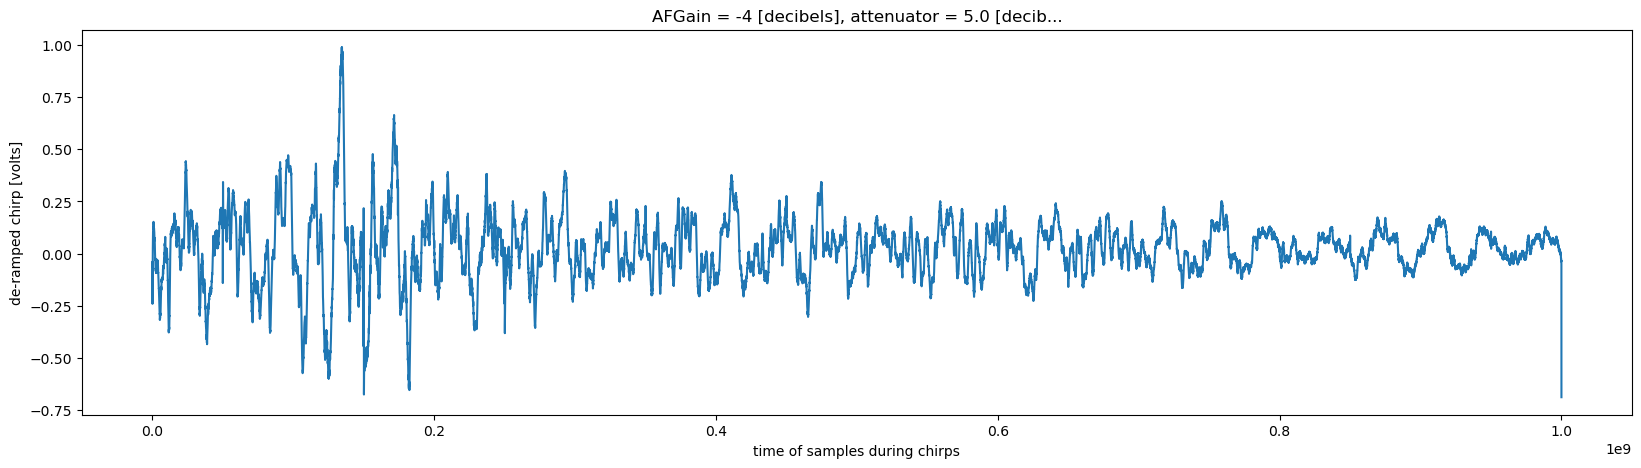

In [17]:
from_zarr.chirp.isel(time=400, chirp_num = 0, attenuator_setting_pair=0).plot(figsize = (20,5));

or stack all the chirps in a particular burst and plot them:

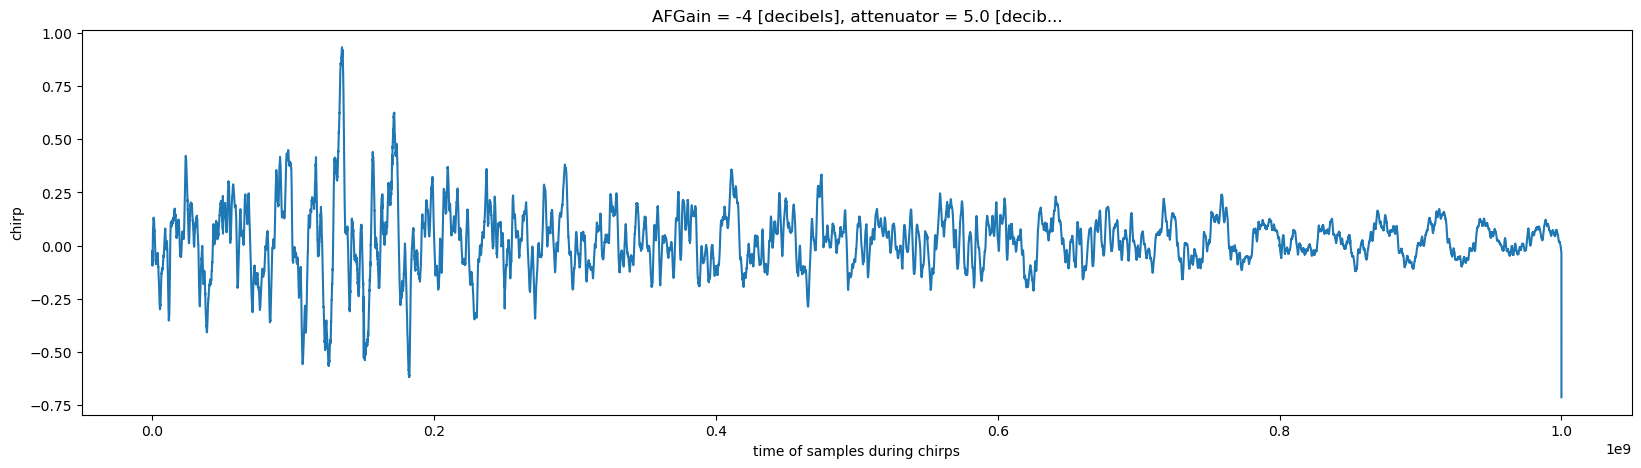

In [18]:
from_zarr.chirp.isel(time=400,attenuator_setting_pair=0).mean(dim='chirp_num').plot(figsize = (20,5));

If we want to plot the amplitude profile we can use a method that is added by the XApRES package when its loaded: `.dB`. It converts the complex profiles stored in `from_zarr.profile` into decibels:

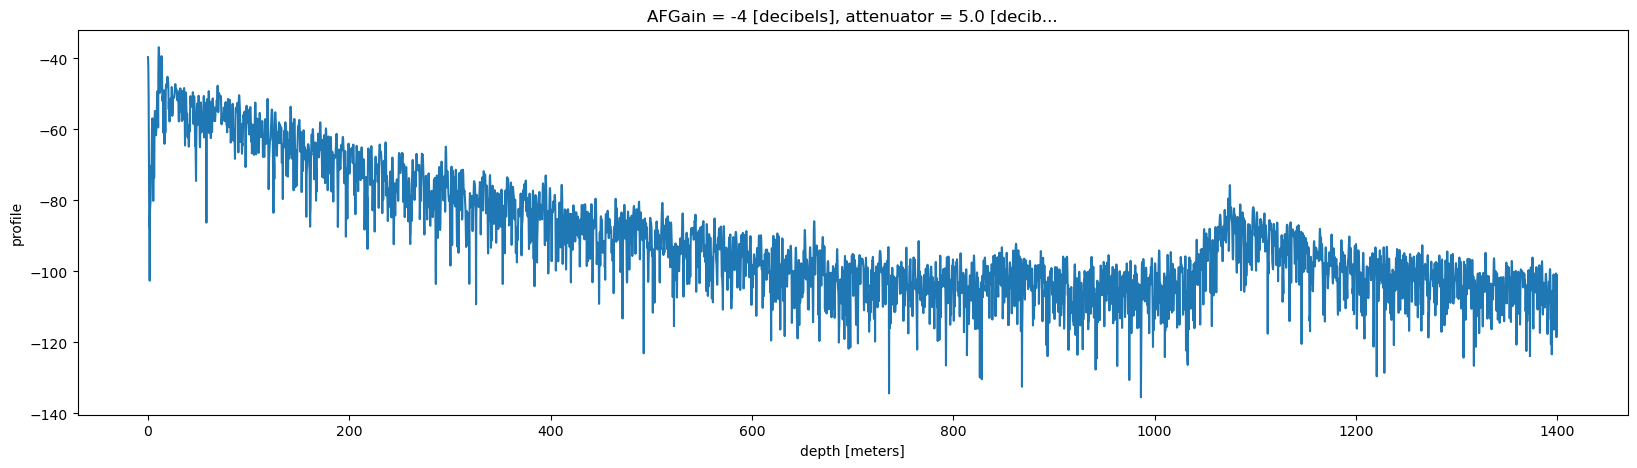

In [19]:
# stack the data
stacked_profile = from_zarr.profile.isel(time=400, attenuator_setting_pair=0).mean(dim='chirp_num')
# compute the decibel profiles
dB = stacked_profile.dB()
# plot the result
dB.plot(figsize = (20,5));

Note that you could do all three commands above in one:

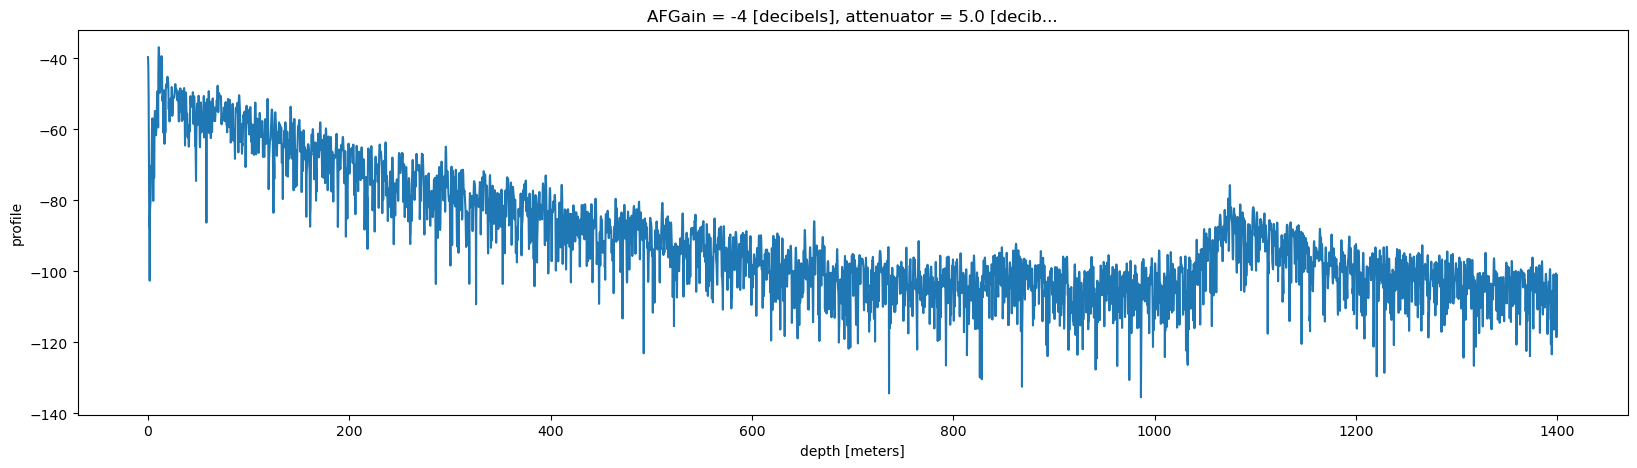

In [20]:
from_zarr.profile.isel(time=400, attenuator_setting_pair=0).mean(dim='chirp_num').dB().plot(figsize = (20,5));

Finally, also note that we compute the stacked profiles during the initial processing of the data when we produce the xarrays. So you could also get the same result by plotting `from_zarr.profile_stacked` directly:

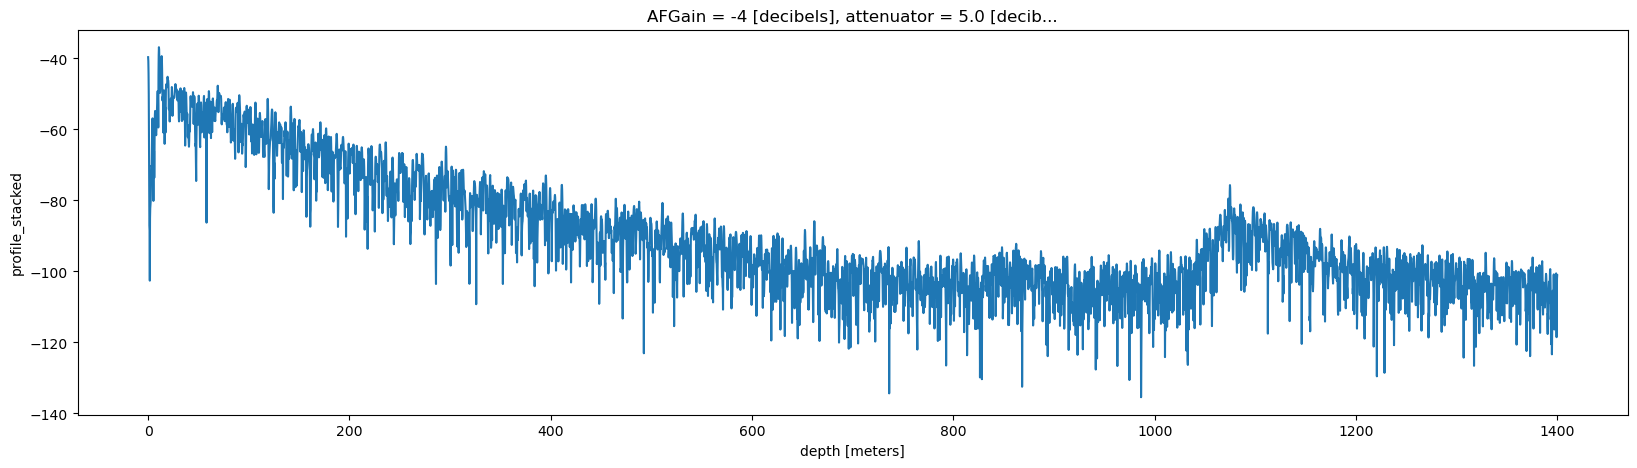

In [21]:
from_zarr.profile_stacked.isel(time=400, attenuator_setting_pair=0).dB().plot(figsize = (20,5));

## Computing displacements
You can use functions built in to XApRES tom compute phase differences between profiles and convert them to displacements, along with the associated uncertainties.

### ...from two profiles

For example, let's load two bursts separated by a 2 days.

In [19]:
p1 = from_zarr.sel(time='2022-07-17').isel(time=0).profile_stacked.load()
p2 = from_zarr.sel(time='2022-07-27').isel(time=0).profile_stacked.load()

Note that in the first line above `from_zarr.sel(time='2022-07-17')` selects al the data from the 17th of JUly 2022, then `.isel(time=0)` selects the first burst from that day. In the second line above the asame thing is done for the 19th. We then also select just the stacked profile (with `.profile_stacked`) and then load the dta into memory with `.load()`; it is lazily loaded by default.



To compute the displacement between the two profiles we use the function `xapres.utils.compute_displacement`  as follows. This produces a  new xarray DataSet containing the original profiles and the following quantities computed in vertical bins
- the coherence between the profiles, 
- the phase difference, 
- the displacement 
- and the uncertainty in the displacement and phase difference.

In [20]:
profiles = xa.utils.compute_displacement(p1, p2)
profiles 

<xarray.Dataset> Size: 515kB
Dimensions:            (attenuator_setting_pair: 2, shot_number: 2,
                        profile_range: 6658, bin: 332)
Coordinates:
    AFGain             (attenuator_setting_pair) int64 16B -4 -14
    attenuator         (attenuator_setting_pair) float64 16B 5.0 5.0
    burst_number       (shot_number) int64 16B 42 62
    filename           (shot_number) <U83 664B 'ldeo-glaciology/GL_apres_2022...
  * profile_range      (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    time               (shot_number) datetime64[ns] 16B 2022-07-17T00:06:51 2...
  * shot_number        (shot_number) int64 16B 1 2
    bin_depth          (bin) float64 3kB 1.998 6.204 ... 1.39e+03 1.394e+03
Dimensions without coordinates: attenuator_setting_pair, bin
Data variables:
    profile_stacked    (shot_number, profile_range, attenuator_setting_pair) complex128 426kB ...
    coherence          (bin, attenuator_setting_pair) complex128 11kB (0.9706...
    phase              (bin, attenuator_setting_pair) float64 5kB -0.04072 .....
    phase_uncertainty  (bin, attenuator_setting_pair) float64 5kB 0.03864 ......
    displacement       (bin, attenuator_setting_pair) float64 5kB -0.001817 ....
    disp_uncertainty   (bin, attenuator_setting_pair) float64 5kB 0.001724 .....
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the compute_displacement function in xapres usin...

From this you can plot the magnitude of the coherence

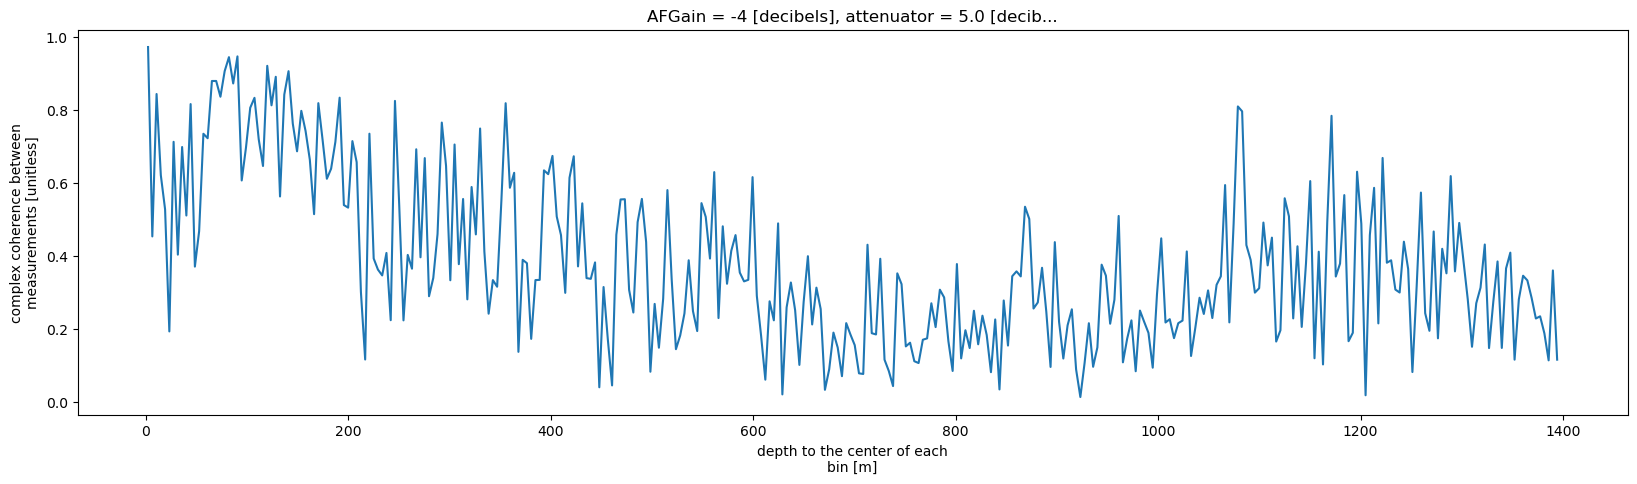

In [21]:
np.abs(profiles.isel(attenuator_setting_pair=0).coherence).plot(figsize = (20,5), x = 'bin_depth');


The phase difference

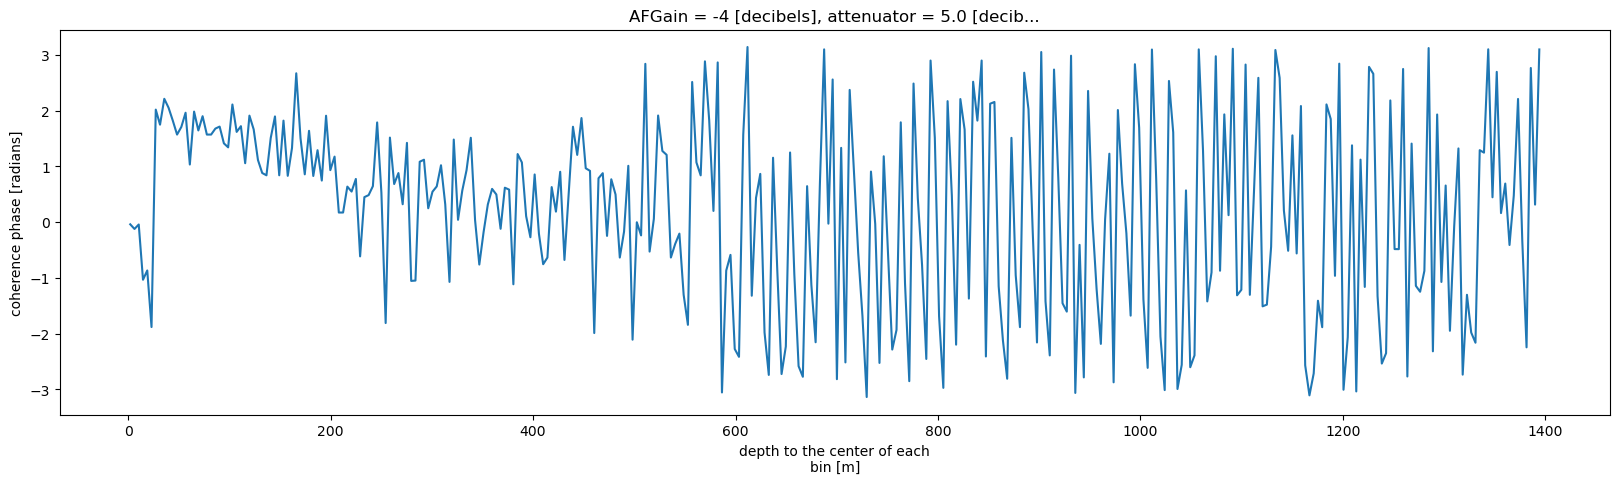

In [22]:
profiles.isel(attenuator_setting_pair=0).phase.plot(figsize = (20,5), x = 'bin_depth');


...or the vertical displacement



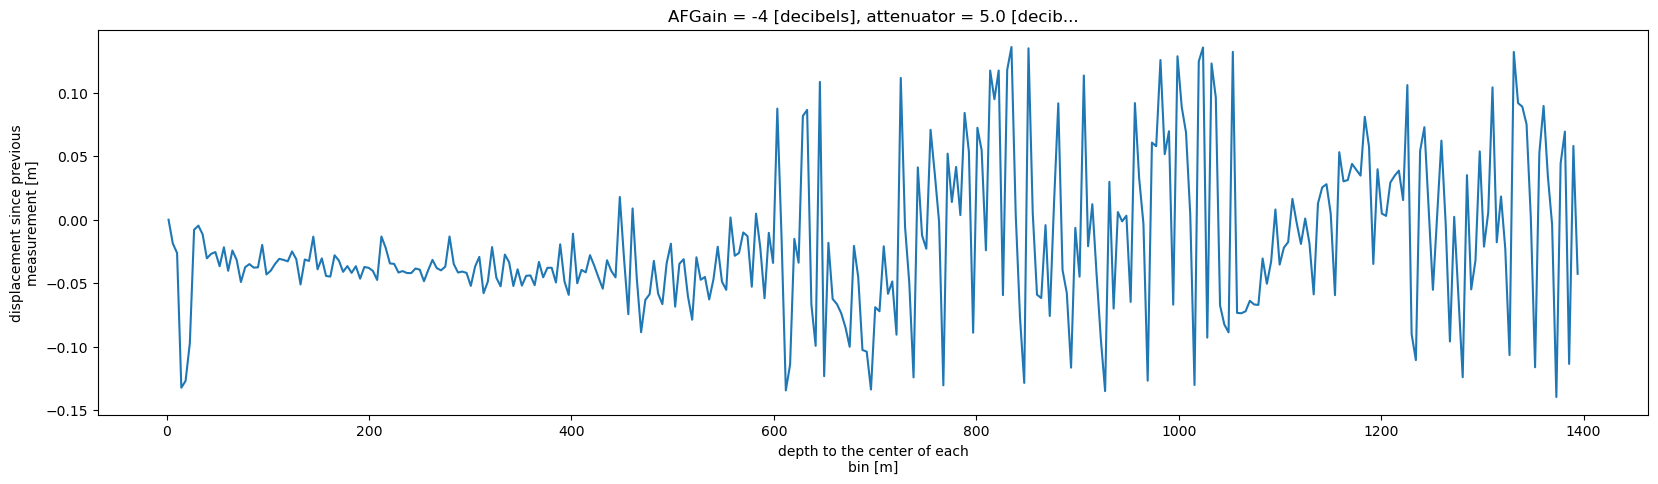

In [18]:
profiles.isel(attenuator_setting_pair=0).displacement.plot(figsize = (20,5), x = 'bin_depth');


### ...from multiple profiles
You can also feed in multipl profiles to `compute_displacement` and it will compute the displacement between each profile and the neighbouring one:

In [23]:
t1 = from_zarr.sel(time='2022-07-17').profile_stacked.isel(time=slice(0,-1))
t2 = from_zarr.sel(time='2022-07-17').profile_stacked.isel(time=slice(1,None))

The cell above takes all the profiles from the 17th July and extracts all-but the last one (`t1`) and the second to the last one (`t2`). 

We can feed this into `compute_displacement` and plot the results:

In [37]:
profiles = xa.utils.compute_displacement(t1, t2).isel(attenuator_setting_pair=0)

In [38]:
profiles

<xarray.Dataset> Size: 22MB
Dimensions:            (shot_number: 2, time: 95, profile_range: 6658, bin: 332)
Coordinates:
    AFGain             int64 8B -4
    attenuator         float64 8B 5.0
    burst_number       (shot_number, time) int64 2kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    filename           (shot_number, time) <U83 63kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * profile_range      (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    profile_time       (shot_number, time) datetime64[ns] 2kB 2022-07-17T00:0...
  * time               (time) datetime64[ns] 760B 2022-07-17T00:14:21.500000 ...
  * shot_number        (shot_number) int64 16B 1 2
    bin_depth          (bin) float64 3kB 1.998 6.204 ... 1.39e+03 1.394e+03
Dimensions without coordinates: bin
Data variables:
    profile_stacked    (shot_number, time, profile_range) complex128 20MB dask.array<chunksize=(1, 15, 6658), meta=np.ndarray>
    coherence          (time, bin) complex128 505kB dask.array<chunksize=(15, 332), meta=np.ndarray>
    phase              (time, bin) float64 252kB dask.array<chunksize=(15, 332), meta=np.ndarray>
    phase_uncertainty  (time, bin) float64 252kB dask.array<chunksize=(15, 332), meta=np.ndarray>
    displacement       (time, bin) float64 252kB dask.array<chunksize=(15, 332), meta=np.ndarray>
    disp_uncertainty   (time, bin) float64 252kB dask.array<chunksize=(15, 332), meta=np.ndarray>
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the compute_displacement function in xapres usin...

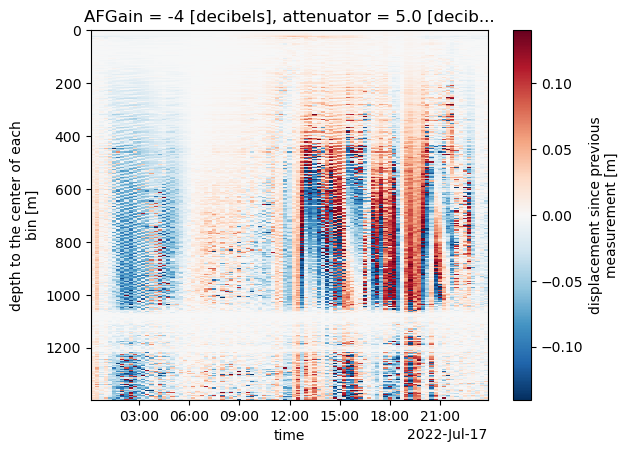

In [35]:
profiles.displacement.plot(y='bin_depth', x='time', yincrease = False)

The method `displacement_timeseries` does this offsetting and computation for you:

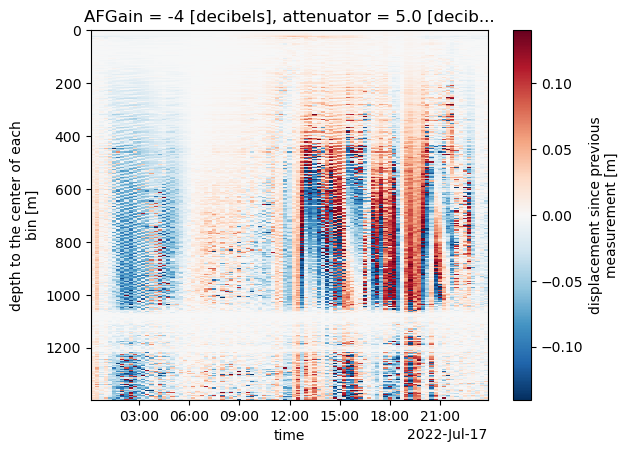

In [44]:
from_zarr.sel(time='2022-07-17').profile_stacked.displacement_timeseries().displacement.isel(attenuator_setting_pair=0).plot(y='bin_depth', x='time', yincrease = False)

With this all packaged up in one line of code, it is easy to explore different days, different vertically bin sizes and different offsets between profiles.

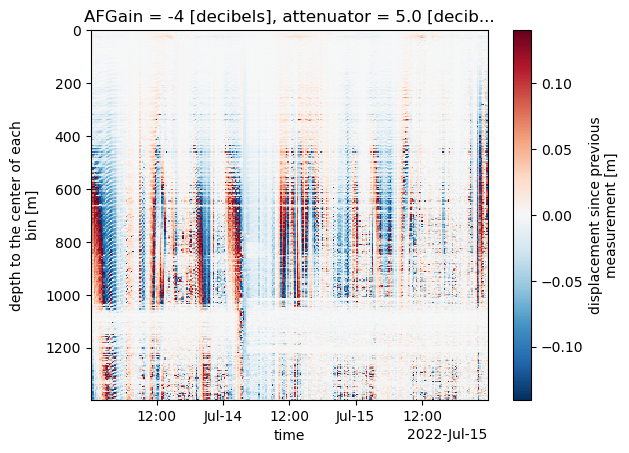

In [46]:
from_zarr.sel(time=slice('2022-07-13', '2022-07-15')).profile_stacked.displacement_timeseries().displacement.isel(attenuator_setting_pair=0).plot(y='bin_depth', x='time', yincrease = False)

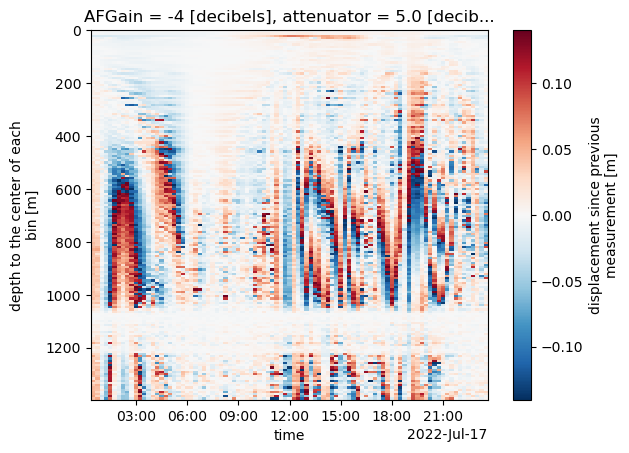

In [47]:
from_zarr.sel(time='2022-07-17').profile_stacked.displacement_timeseries(bin_size = 40, offset = 3).displacement.isel(attenuator_setting_pair=0).plot(y='bin_depth', x='time', yincrease = False)

## Sonfiying the ApRES data
As described [here](https://ldeo-glaciology.github.io/glaciology-intro-book/sections/radar/apres/theory_1.html#compute-the-frequency-difference), the chirps have frequencies in the kHz range are are therefore auduble to humans and can be straightforwardly 'sonified', i.e. turned in to sound. 

The method `.sonify()` is added to xarrays produced by XApRES. It plays the chirp through your computer's speakers and, optionally, saved the sound in a common sound format (.wav). 

It requires two additional packages that can be installed with

In [22]:
!pip install sounddevice soundfile

The following code calls the sonify method. Note that in this case you first need to load the data to disk with `.load()` because the data is only alzily loaded in from_zarr by default. The methods we applied to lazily loaded data above (e.g., `.mean()` and `.plot()`) are designed to deal with lazily loaded data, but the functions used within `.sonify()` are not, hence why you need to fully load the chirp to disk before applying `.sonify()`:

In [23]:
from_zarr.chirp.isel(time=300, chirp_num=0, attenuator_setting_pair=0).load().sonify(save = True)

This should have played a one second sound and produced a new file called 'chirp.wav'